In [1]:
import networkx as nx
import numpy as np
from networkx.generators.community import planted_partition_graph
import torch
from torch_geometric.utils import *
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.nn import PairwiseDistance
from torch import matmul,transpose 
from torch_geometric.nn import SAGEConv
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [223]:
k = 2
G2 = planted_partition_graph(k,1000,0.1,0.0001,seed=42)

In [224]:
combinations = []
for node in G2.nodes():
    for key,lista in dict(nx.bfs_successors(G2,node,2)).items():
        for n in lista:
            combinations.append((node,n))

In [225]:
J = nx.jaccard_coefficient(G2,combinations)

In [226]:
V = len(G2)
simmilarity = np.zeros((V,V))
for u, v, p in J:
    simmilarity[u,v] = p

In [227]:
simmilarity

array([[0.        , 0.06145251, 0.03225806, ..., 0.        , 0.        ,
        0.        ],
       [0.06145251, 0.        , 0.03061224, ..., 0.        , 0.        ,
        0.        ],
       [0.03225806, 0.03061224, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.06842105,
        0.03723404],
       [0.        , 0.        , 0.        , ..., 0.06842105, 0.        ,
        0.05      ],
       [0.        , 0.        , 0.        , ..., 0.03723404, 0.05      ,
        0.        ]])

In [228]:
np.max(simmilarity)

0.1488095238095238

In [229]:
degrees_dict = dict(G2.degree())
degrees = np.array([degrees_dict[key] for key in degrees_dict.keys()],dtype=np.double)
ranks_dict = nx.algorithms.link_analysis.pagerank_alg.pagerank_numpy(G2)
ranks = np.array([ranks_dict[key] for key in ranks_dict.keys()],dtype=np.double)

In [230]:
degrees /= degrees.max()
ranks /= ranks.max()
#X = np.column_stack([degrees,ranks])
for node in G2.nodes():
    G2.nodes[node]['degree'] = degrees[node]
    G2.nodes[node]['rank'] = ranks[node]

In [231]:
G2.nodes[0]['degree'].dtype

dtype('float64')

In [232]:
A = nx.linalg.graphmatrix.adjacency_matrix(G2).toarray()

In [456]:
data = from_networkx(G2,group_node_attrs=['rank','degree'])

In [457]:
data_.num_node_features

2

In [253]:
def getBelongings(G):
    node_belonging = []
    for node in G.nodes():
        kin = total = 0
        node_community = G.nodes[node]["block"]
        for n in G.neighbors(node):
            total += 1
            if G.nodes[n]["block"] == node_community:
                kin += 1
        node_belonging.append(kin/total)
    return node_belonging
node_belongings = getBelongings(G2)

# SIMPLE GCN

In [506]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [411]:
pdist = PairwiseDistance(p=2)
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [459]:
data.x = Tensor.float(data.x)
#simmilarity += np.diag(np.eye(len(G2)))
simmilarity = Tensor(simmilarity)

In [413]:
out = total = 0
dist = Tensor([[70000]])
model.train()
while Tensor.sum(dist) > 7000 and total < 500:
    optimizer.zero_grad()
    out = model(data)
    out_trans = transpose(out,0,1)
    result = matmul(out,out_trans)
    dist = pdist(result,simmilarity)
    loss = torch.sum(dist)
    loss.backward()
    optimizer.step()
    total += 1

In [414]:
total

19

In [415]:
print(Tensor.type(Tensor.float(data.x)),Tensor.type(data.edge_index))

torch.FloatTensor torch.LongTensor


In [416]:
out = model(data).detach().numpy()
out

array([[0.9732737 , 0.01696211, 0.00976421],
       [0.9806698 , 0.01250979, 0.00682044],
       [0.98437434, 0.00940774, 0.00621789],
       ...,
       [0.9780759 , 0.01347133, 0.00845269],
       [0.98522055, 0.00917599, 0.00560355],
       [0.98457134, 0.00925095, 0.00617765]], dtype=float32)

In [417]:
out_trans = out.T
result = np.matmul(out,out_trans)
dist = result-simmilarity.detach().numpy()
dist = dist**2

In [418]:
dist.sum()

19150.219

Text(0, 0.5, 'Pertencimento retornado pelo algoritmo')

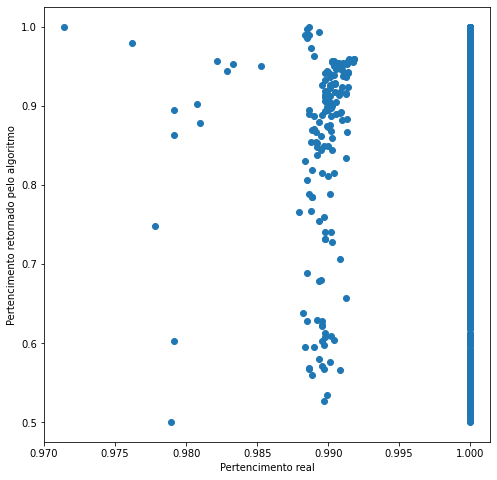

In [419]:
GMM = GaussianMixture(n_components=k,covariance_type='full')
GMM.fit(out)
gmm_labels = GMM.predict_proba(out)
structure_found = np.max(gmm_labels,axis=1)
plt.figure(figsize=(8,8))
plt.scatter(node_belongings,structure_found)
plt.xlabel("Pertencimento real")
plt.ylabel("Pertencimento retornado pelo algoritmo")

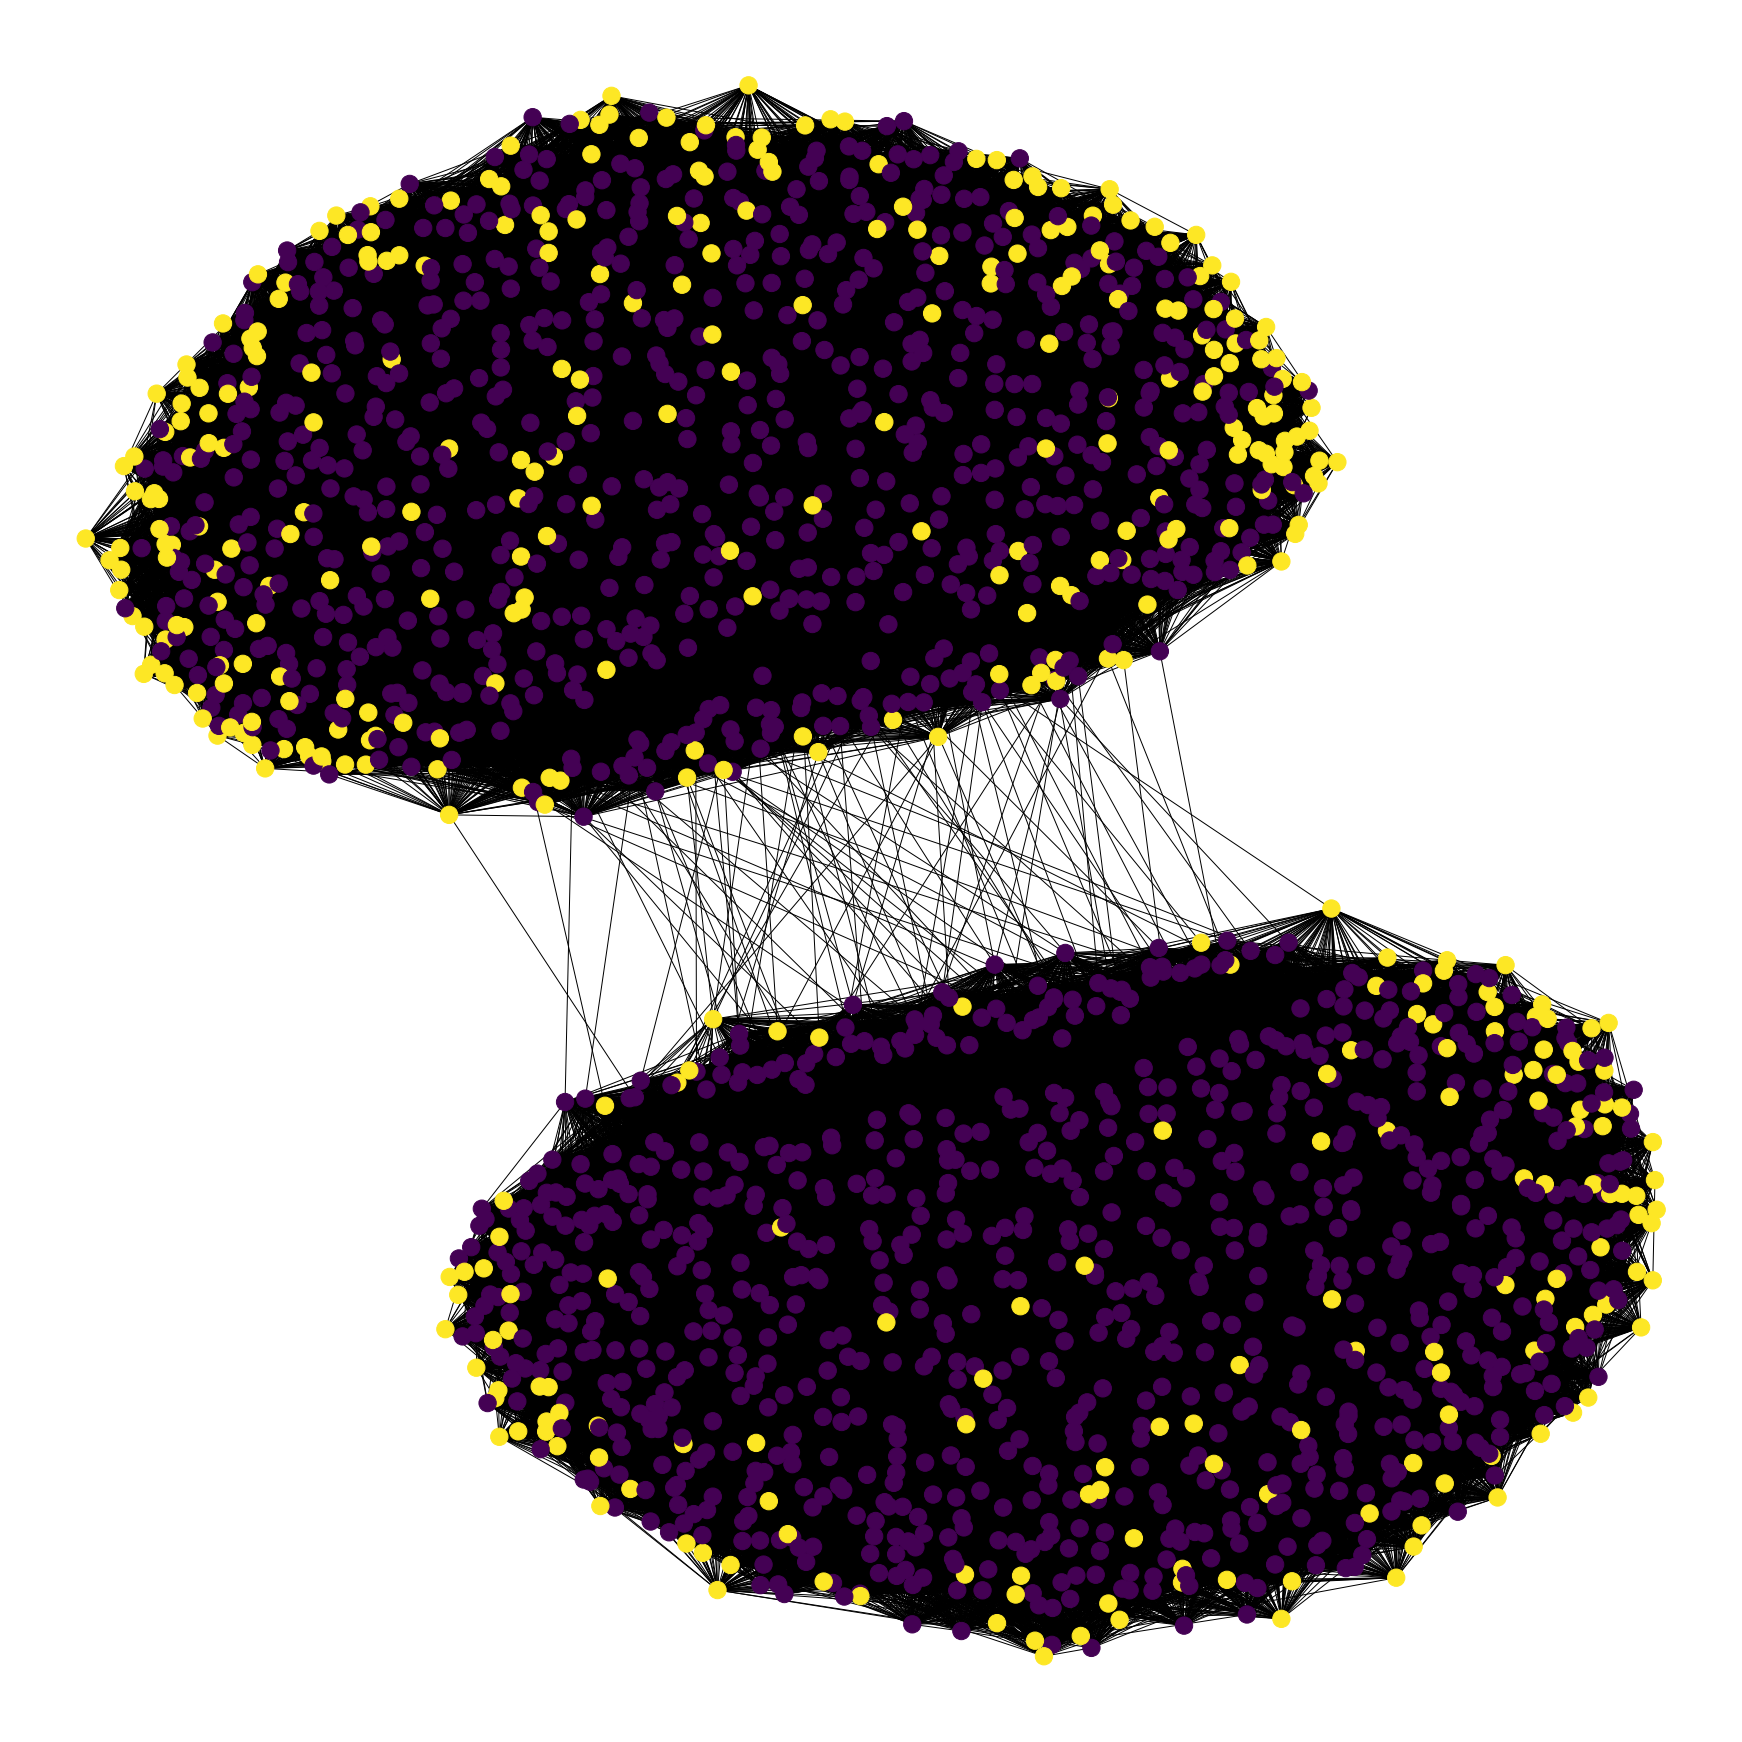

In [420]:
plt.figure(figsize=(24,24))
pos = nx.nx_agraph.graphviz_layout(G2)
nx.draw(G2,pos=pos, node_color=np.argmax(gmm_labels,axis=1))

# GraphSAGE

In [501]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = SAGEConv(data.num_features,
                             2,
                             aggr="mean")
    def forward(self,data):
        x = self.conv(data.x, data.edge_index)
        return F.softmax(x, dim=1)

In [502]:
out = total = 0
dist = Tensor([[70000]])
model = Net()
model.train()
while Tensor.sum(dist) > 7000 and total < 500:
    optimizer.zero_grad()
    out = model(data)
    out_trans = transpose(out,0,1)
    result = matmul(out,out_trans)
    dist = pdist(result,simmilarity)
    loss = torch.sum(dist)
    loss.backward()
    optimizer.step()
    total += 1

In [503]:
total

500

Text(0, 0.5, 'Pertencimento retornado pelo algoritmo')

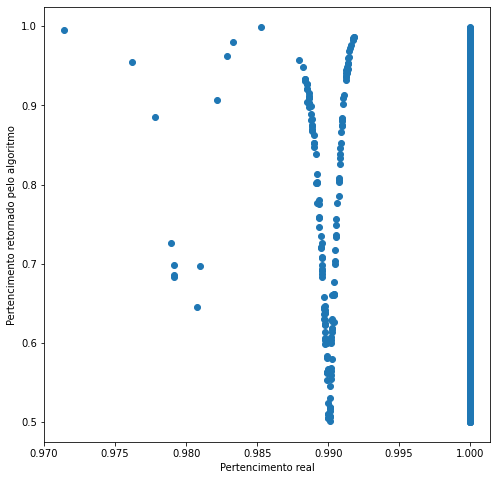

In [504]:
out = model(data).detach().numpy()
GMM = GaussianMixture(n_components=k,covariance_type='full')
GMM.fit(out)
gmm_labels = GMM.predict_proba(out)
structure_found = np.max(gmm_labels,axis=1)
plt.figure(figsize=(8,8))
plt.scatter(node_belongings,structure_found)
plt.xlabel("Pertencimento real")
plt.ylabel("Pertencimento retornado pelo algoritmo")

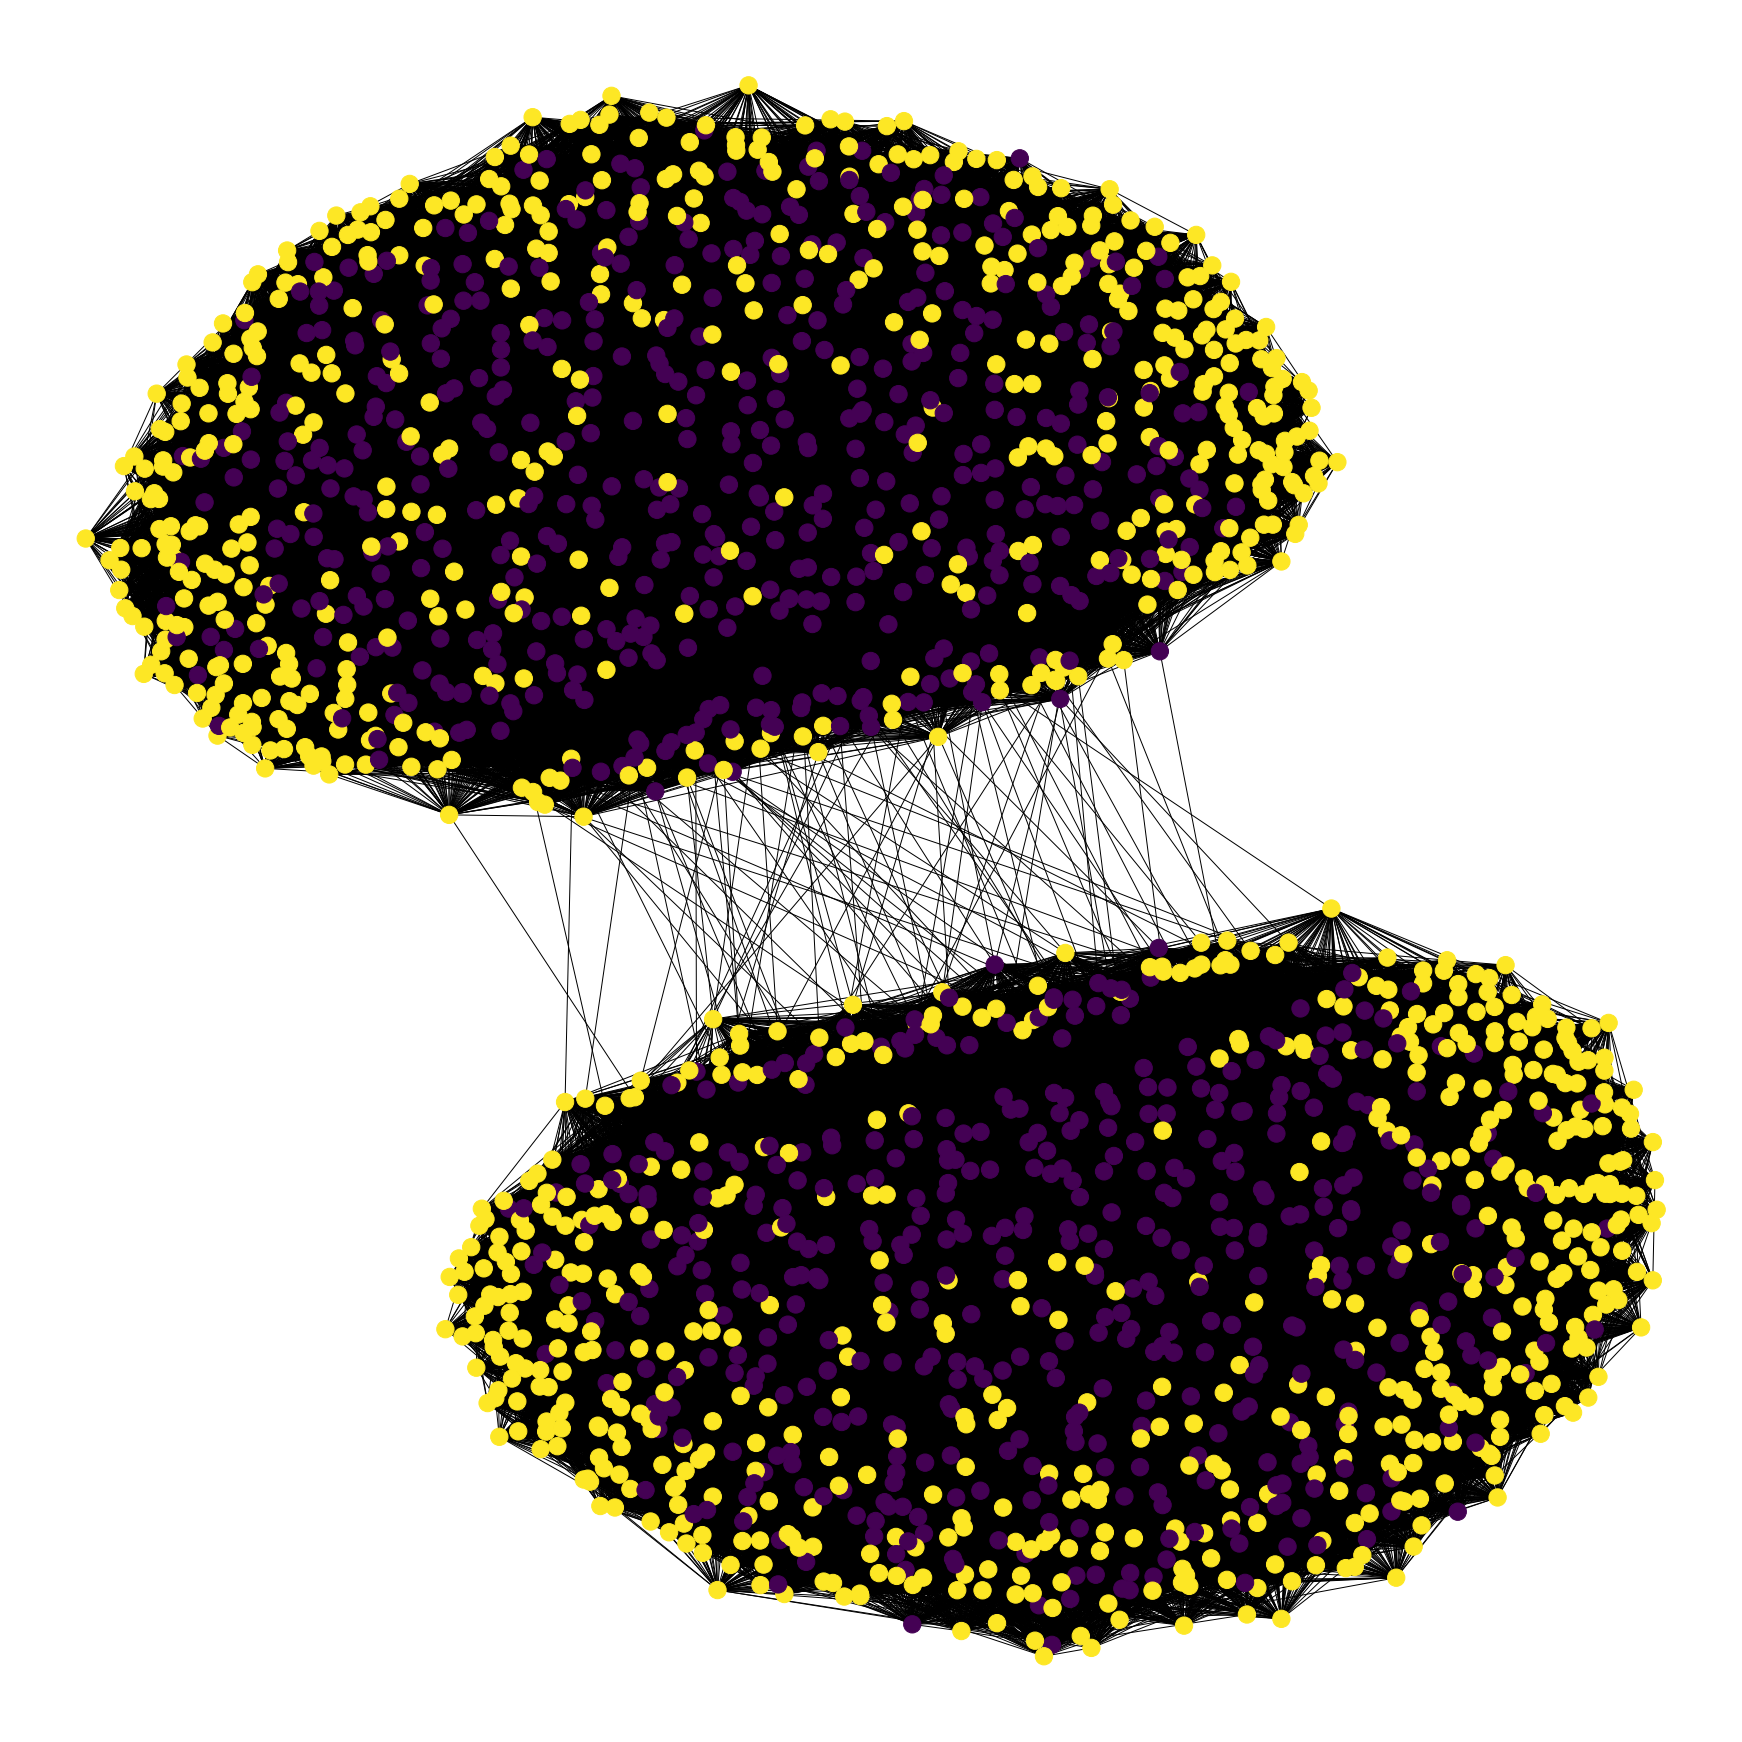

In [505]:
plt.figure(figsize=(24,24))
pos = nx.nx_agraph.graphviz_layout(G2)
nx.draw(G2,pos=pos, node_color=np.argmax(gmm_labels,axis=1))

# Supervised approch

In [541]:
out = total = 0
dist = Tensor([[70000]])
model = GCN()
model.train()
while total < 200:
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out,data.block)
    loss.backward()
    optimizer.step()
    total += 1

In [544]:
data.block

tensor([0, 0, 0,  ..., 1, 1, 1])

In [545]:
out = model(data).detach().numpy()
out

array([[-0.35902023, -1.1985219 ],
       [-0.30919102, -1.3244114 ],
       [-0.33695057, -1.2515681 ],
       ...,
       [-0.33555466, -1.2550608 ],
       [-0.29665598, -1.359846  ],
       [-0.35611597, -1.2052784 ]], dtype=float32)

(array([  8.,  58., 195., 371., 549., 487., 247.,  74.,   9.,   2.]),
 array([-0.39936608, -0.38417593, -0.36898577, -0.35379562, -0.33860543,
        -0.32341528, -0.30822513, -0.29303497, -0.27784482, -0.26265466,
        -0.2474645 ], dtype=float32),
 <BarContainer object of 10 artists>)

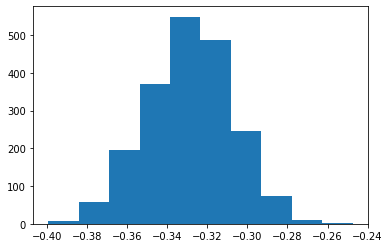

In [546]:
plt.hist(out[:,0])

(array([  2.,   3.,  26., 105., 320., 529., 544., 323., 131.,  17.]),
 array([-1.5176699, -1.4769952, -1.4363205, -1.395646 , -1.3549713,
        -1.3142966, -1.2736219, -1.2329472, -1.1922727, -1.151598 ,
        -1.1109233], dtype=float32),
 <BarContainer object of 10 artists>)

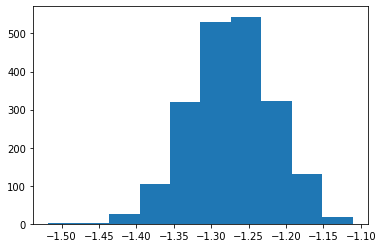

In [547]:
plt.hist(out[:,1])

In [548]:
pred = model(data).argmax(dim=1)
correct = (pred == data.block).sum()
acc = int(correct) / int(data.block.shape[0])
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.5000


In [549]:
correct

tensor(1000)

Text(0, 0.5, 'Pertencimento retornado pelo algoritmo')

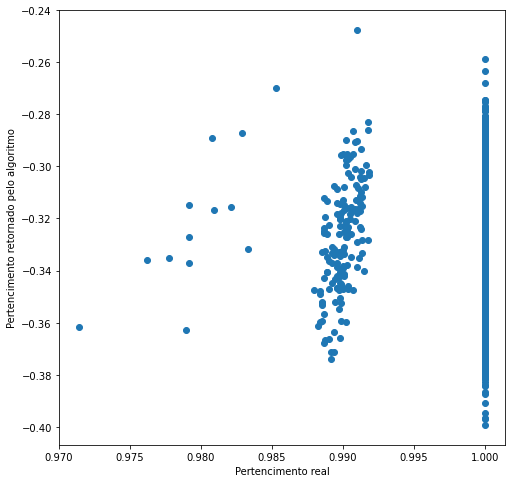

In [550]:
structure_found = np.max(out,axis=1)
plt.figure(figsize=(8,8))
plt.scatter(node_belongings,structure_found)
plt.xlabel("Pertencimento real")
plt.ylabel("Pertencimento retornado pelo algoritmo")

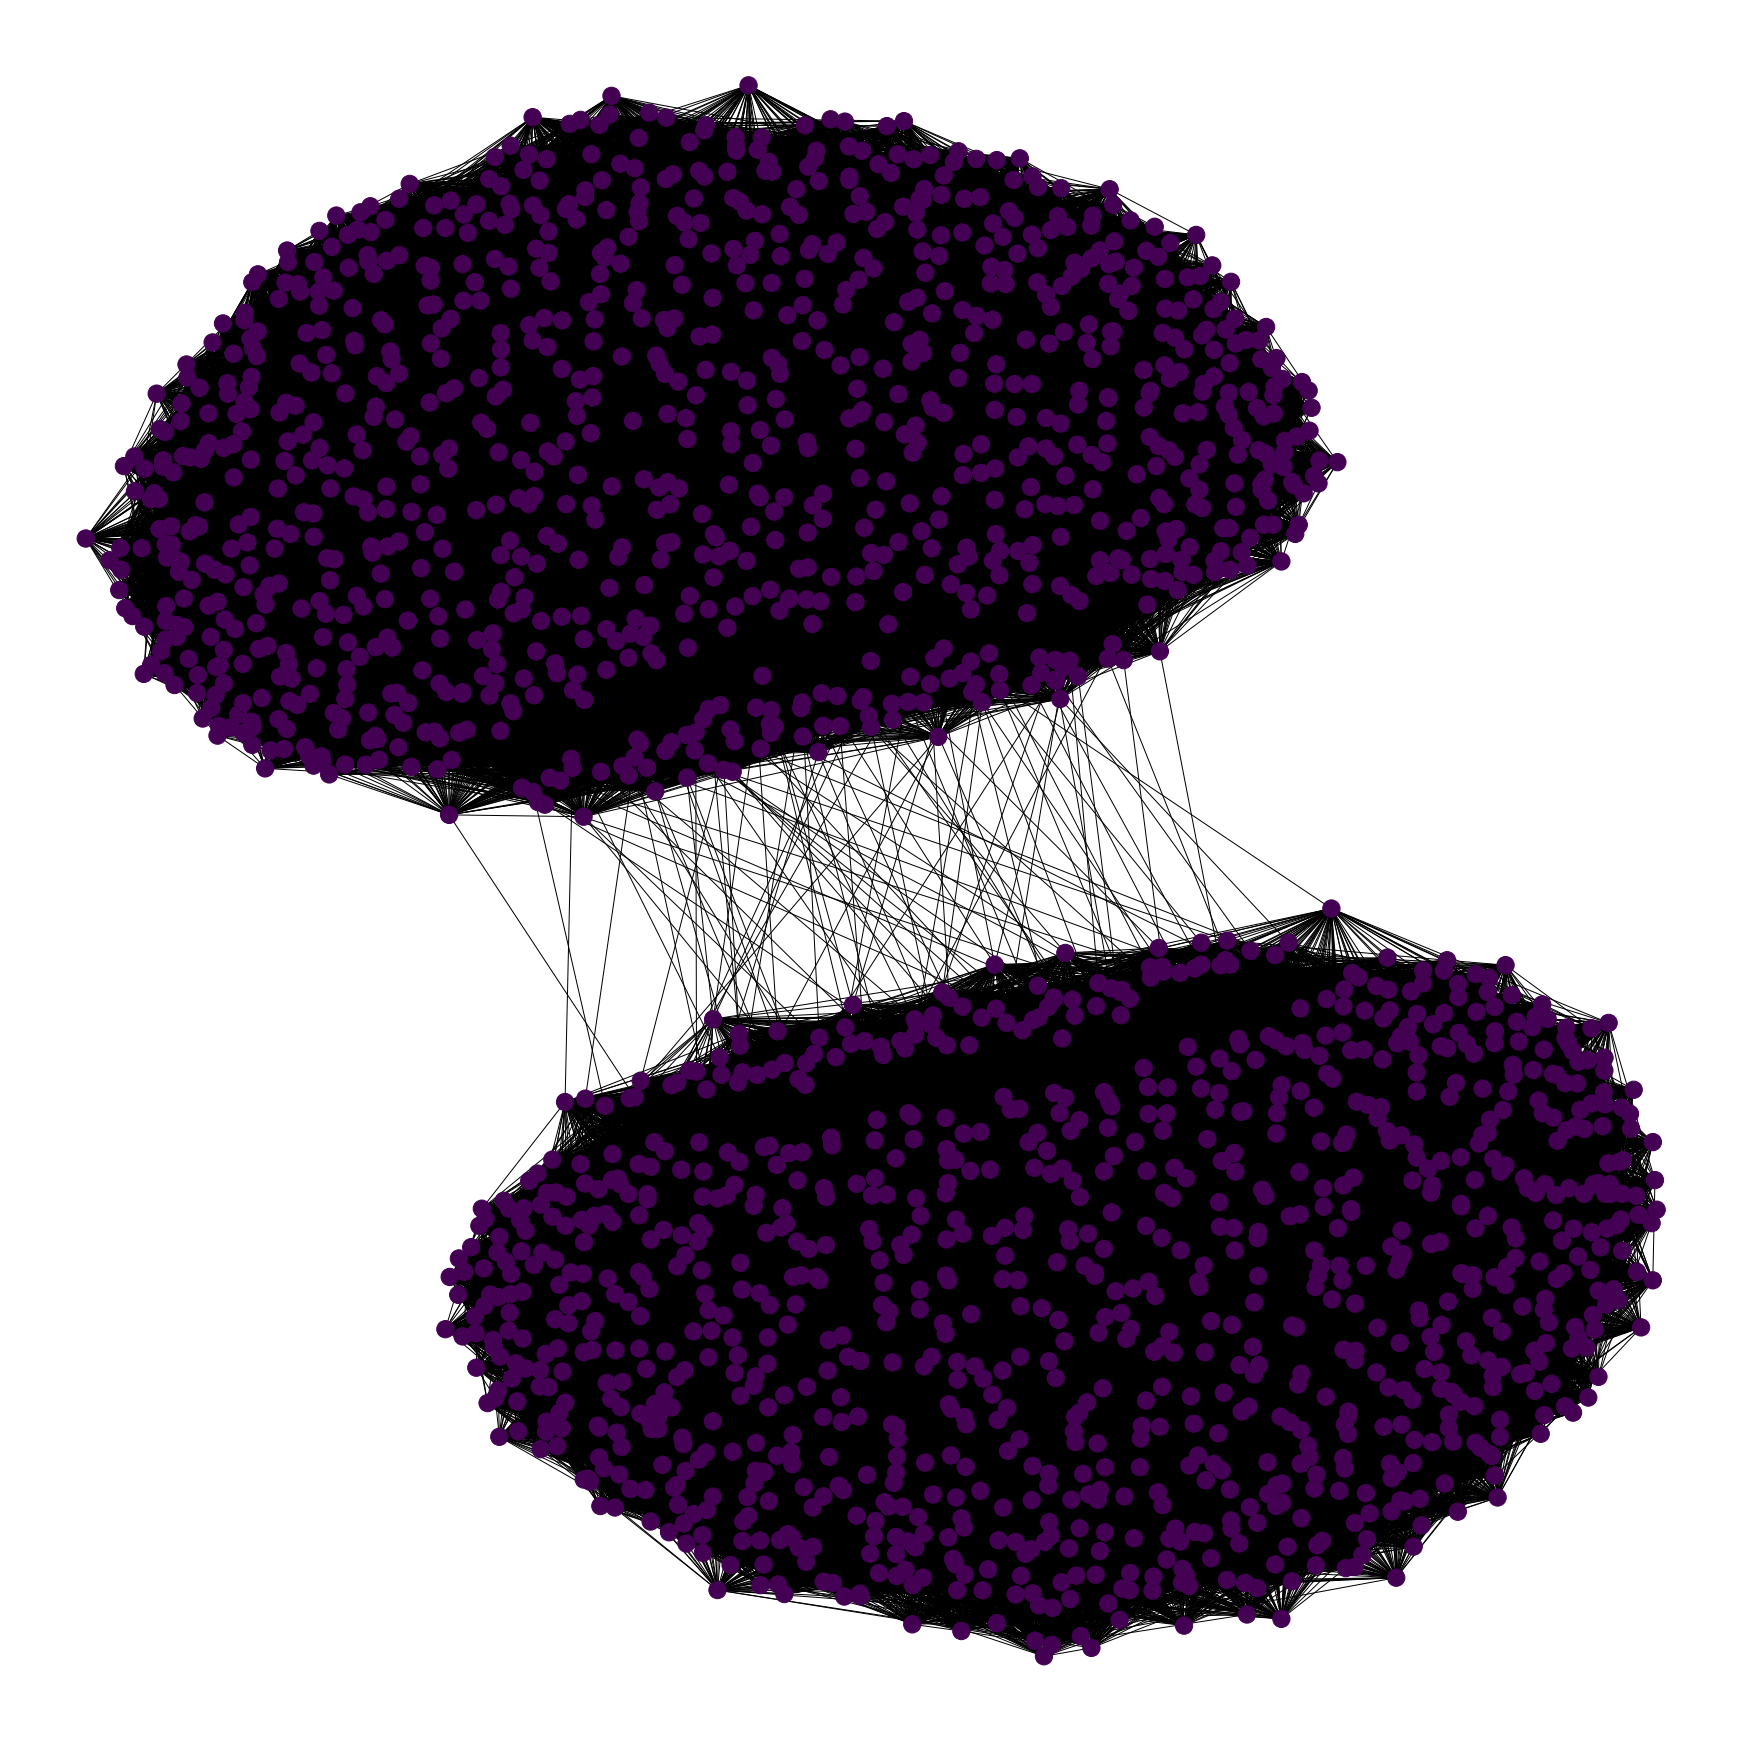

In [552]:
plt.figure(figsize=(24,24))
pos = nx.nx_agraph.graphviz_layout(G2)
nx.draw(G2,pos=pos, node_color=np.argmax(out,axis=1))